In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
from scipy.optimize import minimize_scalar
import json
from scipy.spatial import ConvexHull

In [2]:
params = {'font.size': 16,
          'axes.labelsize': 'large'}

plt.rcParams.update(**params)

## Read data

In [3]:
df = pd.read_json('data/angle_dimer_fits_121120.json')

n_p = df.n_p
a_p = df.a_p
theta = df.theta
d_fit = 2. * df['a_p^*']
n_fit = df['n_p^*']

In [4]:
tdf = pd.read_json('data/angle_trimer_fits_012521.json')

td_fit = 2. * tdf['a_p^*']
tn_fit = tdf['n_p^*']
ttheta = tdf.theta
talpha = tdf.alpha
tphi = tdf.phi

In [5]:
def model(theta, poly):
    return poly(np.sin(theta)**2)

dpoly = np.poly1d(np.polyfit(np.sin(theta)**2, d_fit, 3))
npoly = np.poly1d(np.polyfit(np.sin(theta)**2, n_fit, 3))

th = np.linspace(0, np.pi/2.)
d_m = model(th, dpoly)
n_m = model(th, npoly)

In [6]:
z_fit = df['z_p^*']*0.120

zdiff = z_fit - df.z_p

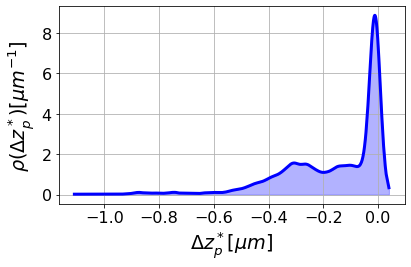

In [10]:
zkernel = stats.gaussian_kde(zdiff, bw_method=0.1)
rho_dz = zkernel(np.sort(zdiff))

fig, ax = plt.subplots()
ax.grid()
ax.set_xlabel(r'$\Delta z_p^* [\mu m]$')
ax.set_ylabel(r'$\rho(\Delta z_p^*) [\mu m^{-1}]$')
ax.plot(np.sort(zdiff), rho_dz, linewidth=3, c='b')
ax.fill_between(np.sort(zdiff), 0, rho_dz, color='b', alpha=0.3)
fig.tight_layout()
fig.savefig('figures/rho_z_error01.png')

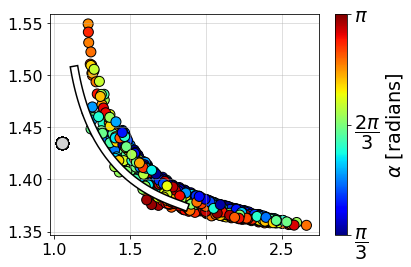

In [11]:
fig, ax = plt.subplots()
ax.scatter(2*a_p, n_p, color='lightgray', ec='k', s=150, label='Monomer')
ct = ax.scatter(td_fit, tn_fit, s=100, c=talpha, cmap = 'jet',  ec='black', vmin=np.pi/3, vmax=np.pi, zorder=1)
ax.plot(d_m, n_m, c='white', linewidth=6, zorder=10, linestyle='-', label='Dimers')
ax.plot(d_m, n_m, c='black', linewidth=9, zorder=9, linestyle='-')
cb= fig.colorbar(ct, ax=ax, ticks =[np.pi/3, np.pi*2/3, np.pi])
cb.set_label(r'$\alpha$ [radians]')
cb.ax.set_yticklabels([r'$\dfrac{\pi}{3}$', r'$\dfrac{2\pi}{3}$', r'$\pi$'])
cb.ax.tick_params(labelsize='large')
ax.grid(alpha=0.5)
fig.tight_layout()

fig.savefig('figures/trimer_alpha_compare02.png')

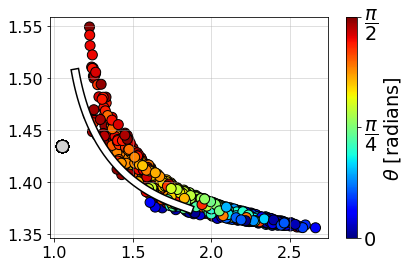

In [12]:
fig, ax = plt.subplots()
ax.scatter(2*a_p, n_p, color='lightgray', ec='k', s=150, label='Monomer')
ct = ax.scatter(td_fit, tn_fit, s=100, c=ttheta, cmap = 'jet',  ec='black', vmin=0, vmax=np.pi/2, zorder=1)
ax.plot(d_m, n_m, c='white', linewidth=6, zorder=10, linestyle='-', label='Dimers')
ax.plot(d_m, n_m, c='black', linewidth=9, zorder=9, linestyle='-')
cb = fig.colorbar(ct, ax=ax, ticks=[0, np.pi/4, np.pi/2])
cb.set_label(r'$\theta$ [radians]')
cb.ax.set_yticklabels(['0', r'$\dfrac{\pi}{4}$', r'$\dfrac{\pi}{2}$'])
cb.ax.tick_params(labelsize='large')

ax.grid(alpha=0.5)
fig.tight_layout()

fig.savefig('figures/trimer_theta_compare01.png')